In [1]:
import json
from collections import defaultdict

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models

2025-01-22 23:10:57.064145: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
with open('../sample-data/fullsample.jsonl', 'r') as f:
    graph_lines = f.readlines()

In [3]:
def as_deployments(graph_entry):
    podToDep = dict()
    depData = defaultdict(list)
    cost = 0
    new_entry = dict()
    for n in graph_entry['nodes']:
        cost += 1
        podToDep[n['id']] = n['deployment']
        depData[n['deployment']].append({'queue_size': n['metrics']['metrics']['queue_size'], 'queue_use': n['metrics']['metrics']['queue_use']})
    
    newNodes = []
    for (key, value) in depData.items():
        new_entry[key] = {'queue_size': 0, 'queue_use': 0, 'replicas': 0}
        for n in value:
            new_entry[key]['replicas'] += 1
            for k, v in n.items():
                new_entry[key][k] += v
        # newNodes.append(node)
    
    # edgeSet = set()
    # for e in graph_entry['edges']:
        # e['source'] = podToDep[e['source']]
#         e['target'] = podToDep[e['target']]
#         edgeSet.add(json.dumps(e))
    #graph_entry['edges'] = [json.loads(e) for e in edgeSet]
    # graph_entry['nodes'] = newNodes
    # graph_entry['network_data']['network_cost'] = cost
    new_entry['total_rejected'] = graph_entry['network_data']['total_rejected']
    return new_entry

In [4]:
data = pd.json_normalize(
    [
        as_deployments(json.loads(entry))
        for entry in graph_lines
    ])
results = data.pop('total_rejected')

In [5]:
results

0        0
1        0
2       11
3       12
4       12
        ..
2359     5
2360     4
2361     4
2362     7
2363     3
Name: total_rejected, Length: 2364, dtype: int64

In [6]:
data_train, data_test, labels_train, labels_test = train_test_split(data, results, test_size=0.2, random_state=42)

In [7]:
def plot(histories):
    epochs = range(1, len(histories[0]['loss'])+1)

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    for i in range(len(histories)):
        history = histories[i]
        if i == 0:
            plt.plot(epochs, history['mean_absolute_error'], 'b', label='Erro médio absoluto de treino')
        else:
            plt.plot(epochs,history['mean_absolute_error'], 'b')
        if i == 0:
            plt.plot(epochs, history['val_mean_absolute_error'], 'r--', label='Erro médio absoluto de validação')
        else:
            plt.plot(epochs, history['val_mean_absolute_error'], 'r--')

    plt.title(f'Erros empírico e de validação')
    plt.xlabel('Epochs')
    plt.ylabel('Erro')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [8]:
def train_kfold(model, data_train, labels_train, epochs, batch_size):
    histories = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for train_i, validate_i in kf.split(data_train):
        data_train_fold, data_train_validation = data_train.iloc[train_i], data_train.iloc[validate_i]
        labels_train_fold, labels_train_validation = labels_train.iloc[train_i], labels_train.iloc[validate_i]

        history = model.fit(data_train_fold, labels_train_fold, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(data_train_validation, labels_train_validation))
        histories.append(history.history)

    return model, histories

In [9]:
model = models.Sequential([
    layers.Dense(10, activation='relu', input_shape=(data_train.shape[1],)),
    layers.Dense(5, activation='relu'),
    layers.Dense(5, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

/Users/henriquefurst/.asdf/installs/python/3.11.3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 36.1996 - mean_absolute_error: 4.7798 - val_loss: 28.7195 - val_mean_absolute_error: 4.2382
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27.1180 - mean_absolute_error: 4.0844 - val_loss: 24.7067 - val_mean_absolute_error: 3.8627
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22.1556 - mean_absolute_error: 3.6784 - val_loss: 23.1940 - val_mean_absolute_error: 3.7252
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.3777 - mean_absolute_error: 3.5495 - val_loss: 21.8904 - val_mean_absolute_error: 3.5738
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.1149 - mean_absolute_error: 3.4132 - val_loss: 20.7159 - val_mean_absolute_error: 3.4999
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.3252 - mean_absolute_error: 3.3255 - val_loss: 19.9335 - val_mean_absolute_error: 3.4266
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.7129 - mean_absolute_error: 3.3028 - va

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.6766 - mean_absolute_error: 2.5541 - val_loss: 14.1046 - val_mean_absolute_error: 2.7863
Epoch 46/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.6281 - mean_absolute_error: 2.5939 - val_loss: 14.0013 - val_mean_absolute_error: 2.7827
Epoch 47/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.0494 - mean_absolute_error: 2.6399 - val_loss: 14.2237 - val_mean_absolute_error: 2.7968
Epoch 48/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.8048 - mean_absolute_error: 2.6006 - val_loss: 13.9030 - val_mean_absolute_error: 2.7714
Epoch 49/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.6035 - mean_absolute_error: 2.6865 - val_loss: 13.8033 - val_mean_absolute_error: 2.7679
Epoch 50/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.9790 - mean_absolute_error: 2.6384 - val_loss: 13.7428 - val_mean_absolute_error: 2.7559
Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11.4172 - mean_absolute_error: 2.5777 - val_loss

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.4825 - mean_absolute_error: 2.2812 - val_loss: 11.3023 - val_mean_absolute_error: 2.5848
Epoch 40/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.6773 - mean_absolute_error: 2.3483 - val_loss: 11.2858 - val_mean_absolute_error: 2.5850
Epoch 41/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.1589 - mean_absolute_error: 2.3850 - val_loss: 11.2277 - val_mean_absolute_error: 2.5830
Epoch 42/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.2560 - mean_absolute_error: 2.4029 - val_loss: 11.2676 - val_mean_absolute_error: 2.5825
Epoch 43/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.0631 - mean_absolute_error: 2.4041 - val_loss: 11.1825 - val_mean_absolute_error: 2.5816
Epoch 44/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.3286 - mean_absolute_error: 2.3268 - val_loss: 11.2022 - val_mean_absolute_error: 2.5788
Epoch 45/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.7497 - mean_absolute_error: 2.3346 - val_loss: 1

Epoch 34/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.4568 - mean_absolute_error: 2.2866 - val_loss: 7.6802 - val_mean_absolute_error: 2.1197
Epoch 35/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.4978 - mean_absolute_error: 2.3488 - val_loss: 7.5948 - val_mean_absolute_error: 2.0944
Epoch 36/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.5577 - mean_absolute_error: 2.3469 - val_loss: 7.5566 - val_mean_absolute_error: 2.0896
Epoch 37/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.8183 - mean_absolute_error: 2.3647 - val_loss: 7.7171 - val_mean_absolute_error: 2.1360
Epoch 38/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.0597 - mean_absolute_error: 2.2621 - val_loss: 7.5106 - val_mean_absolute_error: 2.0840
Epoch 39/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.7822 - mean_absolute_error: 2.3300 - val_loss: 7.9313 - val_mean_absolute_error: 2.1617
Epoch 40/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.4598 - mean_absolute_error: 2.4311 - val_los

Epoch 29/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.9962 - mean_absolute_error: 2.2901 - val_loss: 8.9461 - val_mean_absolute_error: 2.1944
Epoch 30/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.6655 - mean_absolute_error: 2.2225 - val_loss: 8.9169 - val_mean_absolute_error: 2.1838
Epoch 31/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.6609 - mean_absolute_error: 2.2352 - val_loss: 8.9093 - val_mean_absolute_error: 2.1604
Epoch 32/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.4872 - mean_absolute_error: 2.2345 - val_loss: 8.8629 - val_mean_absolute_error: 2.1828
Epoch 33/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.2650 - mean_absolute_error: 2.1869 - val_loss: 8.8339 - val_mean_absolute_error: 2.1733
Epoch 34/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.8785 - mean_absolute_error: 2.2394 - val_loss: 9.1229 - val_mean_absolute_error: 2.1684
Epoch 35/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.7971 - mean_absolute_error: 2.2225 - val_loss

Epoch 24/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.5375 - mean_absolute_error: 2.0469 - val_loss: 8.8041 - val_mean_absolute_error: 2.2757
Epoch 25/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.9589 - mean_absolute_error: 2.1238 - val_loss: 8.8494 - val_mean_absolute_error: 2.2733
Epoch 26/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.2638 - mean_absolute_error: 2.1468 - val_loss: 9.1461 - val_mean_absolute_error: 2.2850
Epoch 27/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.7845 - mean_absolute_error: 2.1725 - val_loss: 8.8439 - val_mean_absolute_error: 2.2756
Epoch 28/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.4527 - mean_absolute_error: 2.1744 - val_loss: 9.0971 - val_mean_absolute_error: 2.3385
Epoch 29/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.5816 - mean_absolute_error: 2.1743 - val_loss: 8.8804 - val_mean_absolute_error: 2.2885
Epoch 30/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.2186 - mean_absolute_error: 2.1619 - val_loss

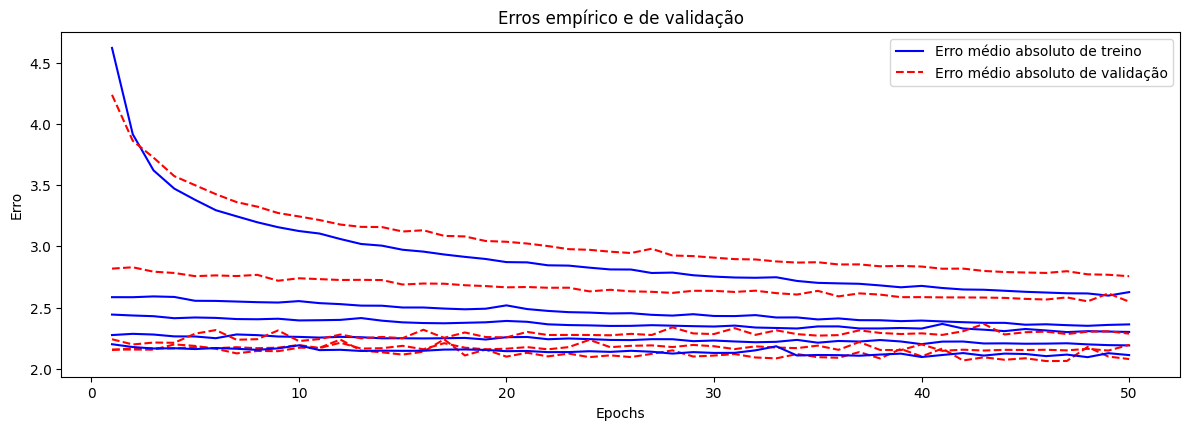

In [10]:
num_model, histories = train_kfold(model, data_train, labels_train, epochs=50, batch_size=50)
plot(histories)

In [11]:
loss, mae = model.evaluate(data_test, labels_test)
print(loss, mae)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 7.2895 - mean_absolute_error: 2.1090
8.105745315551758 2.217803478240967
